<a href="https://colab.research.google.com/github/Song-yiJung/DH-Buddhist-Analysis-Tutorial/blob/main/10_Mean_of_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📜 튜토리얼 10: 문서 전체의 의미 벡터 만들기 (기초편)

이전 학습에서 Word2Vec을 통해 개별 단어의 의미를 벡터(숫자 배열)로 표현하는 방법을 학습함. 그러나 실제 연구에서는 "이 문서와 저 문서의 주제가 얼마나 비슷한가?" 와 같이, 문서 전체를 비교해야 하는 경우가 많음.

본 튜토리얼에서는 Word2Vec으로 학습한 단어 벡터를 활용, **문서 전체의 의미를 단일 벡터로 표현하는 가장 기본적인 방법인 'Mean of Word Embeddings(단어 임베딩 평균내기)'**의 원리와 장점, 그리고 명확한 한계를 확인함.

##1. 핵심 개념: 문서의 의미는 단어 의미들의 '평균'이다.

'Mean of Word Embeddings'의 핵심 아이디어는 단순함.

문서의 전체 의미는, 그 문서를 구성하는 모든 단어의 의미 벡터를 합산한 뒤, 단어의 총 개수로 나누어 평균을 낸 값과 같다고 가정함.

이는 각 단어 벡터가 가진 의미의 방향과 크기를 종합하여, 문서 전체가 가리키는 의미의 중심점을 찾는 과정임.

##2. 장점과 한계: 언제 유용하고, 무엇을 조심해야 할까?
이 단순한 방법은 명확한 장점과 그보다 더 중요한 한계를 가짐.

🟢 장점 (Pros)

**구현의 용이성**: 코드로 구현이 간단하고 계산 속도가 빠름. 문서에 포함된 모든 단어의 벡터를 불러와 산술 평균만 내면 되기 때문임.

빠른 주제 파악: 문서의 전반적인 '주제'나 '의미의 중심점'을 신속히 파악하는 데 효과적임. 예를 들어, 자력신앙과 공(空)사상을 다루는 『금강경』과 타력신앙과 극락왕생을 다루는 『아미타경』은 사용하는 단어군이 완전히 다르므로, 평균을 내도 의미 공간에서 뚜렷하게 구분될 가능성이 높음.

🔴 한계 (Cons)

**단어 순서 및 문법 구조 무시**: BoW(Bag-of-Words)와 같이 단어의 순서를 완전히 무시함. A가 B를 비판했다와 B가 A를 비판했다는 단어 구성이 같아 평균 벡터가 거의 동일하게 나오지만, 의미는 정반대임. 한문처럼 어순이 중요한 텍스트에서 이는 큰 약점임.

**핵심 단어의 의미 희석 (가장 큰 문제)**: 문서 내 모든 단어 벡터를 동일한 가중치로 평균 내므로, 소수 핵심 단어의 중요성이 다수의 일반 단어들로 인해 희석됨.


🍓 딸기 스무디 비유: 좋은 **딸기(🍓, 핵심 단어)**를 넣어도, 물(💧, 之, 乎, 也 같은 의미 없는 허사) 열 컵을 같이 넣고 갈아버리면, 최종 결과물은 딸기 맛이 거의 나지 않는 밍밍한 물맛이 될 것임.


**경전 분석**: 이와 같이, 空(공)이나 菩薩(보살) 같은 핵심 개념어의 벡터가 於(어), 而(이), 其(기) 등 수없이 등장하는 허사들의 벡터와 섞여, 문서의 진짜 주제가 희석되고 벡터의 변별력이 떨어지게 됨.

##3. 실습: 『금강경』과 『아미타경』 비교하기

이제 코드를 통해 직접 문서 벡터를 만들고, 두 경전이 주제적으로 얼마나 다른지 확인해보겠다.

In [ ]:
# 1. 필요 라이브러리 설치 및 업그레이드
!pip install --upgrade numpy scipy requests beautifulsoup4 lxml jieba gensim opencc-python-reimplemented -q

print("✅ 라이브러리 설치 및 업그레이드 완료!")
# [알림] 위 셀 실행 후 버전 충돌 오류가 발생하면, 메뉴에서 [런타임] > [런타임 다시 시작]을 한 번 실행한 뒤 아래 셀을 실행하세요.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
✅ 라이브러리 설치 및 업그레이드 완료!


In [ ]:
# --- 라이브러리 불러오기 ---
import requests
from bs4 import BeautifulSoup
import re
from opencc import OpenCC
import jieba
from gensim.models import Word2Vec
import numpy as np

# --- 1. 데이터 확보 (금강경, 아미타경) ---
urls = {
    'diamond_sutra': 'https://raw.githubusercontent.com/cbeta-org/xml-p5/master/T/T08/T08n0235.xml', # 금강경 (T235)
    'amitabha_sutra': 'https://raw.githubusercontent.com/cbeta-org/xml-p5/master/T/T12/T12n0366.xml' # 아미타경 (T366)
}
documents_raw = []
for key, url in urls.items():
    try:
        response = requests.get(url)
        response.raise_for_status()
        documents_raw.append(response.text)
        print(f"✅ {key} 불러오기 성공!")
    except:
        print(f"오류: {key}를 불러오는 중 문제가 발생했습니다.")
        documents_raw.append("")

# --- 2. 텍스트 추출 및 전처리 ---
def preprocess_text(xml_text):
    soup = BeautifulSoup(xml_text, 'xml')
    text = soup.find('body').get_text()
    text = re.sub(r'\s+', ' ', text)
    return text
cc = OpenCC('t2s')
documents_simplified = [cc.convert(preprocess_text(doc)) for doc in documents_raw]

# --- 3. 토큰화 ---
tokenized_corpus = [jieba.lcut(doc) for doc in documents_simplified]
print("\n✅ 토큰화 완료!")

# --- 4. Word2Vec 모델 훈련 (두 경전을 함께 학습) ---
model = Word2Vec(sentences=tokenized_corpus, sg=1, vector_size=100, window=10, min_count=5, epochs=20, seed=42)
print("✅ Word2Vec 모델 훈련 완료!")

# --- 5. [핵심] 단어 벡터 평균 함수 정의 ---
def get_mean_vector(doc_tokens, model):
    # 모델의 어휘 사전에 있는 단어들만 필터링
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    # 모든 벡터를 더한 뒤, 단어 개수만큼 나누어 평균 벡터를 계산
    return np.mean(vectors, axis=0)

# --- 6. 각 경전의 문서 벡터 계산 ---
vec_diamond = get_mean_vector(tokenized_corpus[0], model)
vec_amitabha = get_mean_vector(tokenized_corpus[1], model)
print("\n✅ 각 경전의 문서 벡터 계산 완료!")

# --- 7. 두 문서 벡터의 유사도 측정 ---
# 코사인 유사도 계산 (1에 가까울수록 유사, 0에 가까울수록 무관)
similarity = np.dot(vec_diamond, vec_amitabha) / (np.linalg.norm(vec_diamond) * np.linalg.norm(vec_amitabha))

print("\n--- 🚀 분석 결과 ---")
print(f"『금강경』과 『아미타경』의 주제적 유사도: {similarity:.4f}")

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...


✅ diamond_sutra 불러오기 성공!
✅ amitabha_sutra 불러오기 성공!


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.799 seconds.
DEBUG:jieba:Loading model cost 0.799 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.



✅ 토큰화 완료!
✅ Word2Vec 모델 훈련 완료!

✅ 각 경전의 문서 벡터 계산 완료!

--- 🚀 분석 결과 ---
『금강경』과 『아미타경』의 주제적 유사도: 0.8738


## 🔬 분석 결과, 무엇을 말해주는가?

실행 결과:

『금강경』과 『아미타경』의 주제적 유사도: 0.8738
이 숫자 0.8738은 두 경전의 '주제적 거리'를 컴퓨터가 계산한 값이다. 코사인 유사도라는 이 값은 1에 가까울수록 "주제가 거의 같다"는 의미이고, 0에 가까울수록 "주제가 매우 다르다"는 의미이다.

결과적으로, 컴퓨터는 두 경전의 주제 유사도를 매우 높게 평가했다. 이는 불교학 연구자의 관점에서 두 경전의 사상적 차이를 고려할 때, 다소 의외의 결과일 수 있다. 이 현상은 바로 우리가 사용한 'Mean of Word Embeddings' 방법론의 명확한 한계를 보여주는 매우 중요한 사례이다.

왜 이런 결과가 나왔는가?: 핵심 단어의 의미 희석
컴퓨터는 두 경전의 고유한 핵심 사상(『금강경』의 '반야/공', 『아미타경』의 '정토/염불')보다, 두 경전이 공통적으로 사용하는 **방대한 양의 '일반 불교 용어'와 '한문 허사(虛辭)'**에 더 큰 영향을 받았다.

딸기 스무디 비유: 『금강경』이라는 '딸기(🍓)'와 『아미타경』이라는 '바나나(🍌)'로 각각 스무디를 만든다고 상상해보자. 이때 두 컵에 공통적으로 물(💧)을 열 컵씩 부었다면 어떻게 될까? 물은 如是我聞, 一時, 佛, 世尊 등 두 경전에 모두 등장하는 공통 어휘에 해당한다. 이 상태에서 평균을 내면, 딸기 맛과 바나나 맛이라는 고유한 특징은 대부분 사라지고, 두 컵 모두 "밍밍한 물맛"이라는 공통점만 남게 된다.

이와 같이, 空(공)이나 阿彌陀佛(아미타불) 같은 핵심 개념어의 벡터가, 수없이 등장하는 공통 단어들의 벡터와 함께 평균내어지면서 두 경전의 고유한 주제적 색채가 희석되고, "전반적으로 불교 경전이다"라는 공통점만 크게 부각되어 높은 유사도 점수가 나온 것이다.

## 💡 이 방법론으로 무엇을 할 수 있는가?: 연구의 새로운 가능성
이러한 한계에도 불구하고, 이 분석은 인문학 연구에 다음과 같은 중요한 통찰과 가능성을 제시한다.

1. 방법론의 한계 인식 및 비판적 해석
이 결과는 디지털 인문학 연구자가 컴퓨터가 내놓은 숫자를 맹신해서는 안 되며, 사용된 방법론의 특징과 한계를 명확히 이해하고 결과를 비판적으로 해석해야 함을 보여준다. "왜 컴퓨터는 다르게 생각했을까?"라는 질문을 통해, 우리는 분석 방법 자체의 특성과 데이터의 편향성을 더 깊이 탐구하게 된다.

2. 거시적 장르 분류의 가능성
이 방법은 세밀한 사상적 차이를 구분하는 데는 약하지만, 매우 다른 장르의 텍스트를 구분하는 데는 효과적일 수 있다. 예를 들어, 『금강경』과 『경국대전』(법전)을 비교했다면, 사용하는 어휘 자체가 완전히 다르므로 매우 낮은 유사도 점수가 나왔을 것이다. 이를 통해 대규모 문헌 아카이브에서 '경전류', '사서류', '법전류' 등 거시적인 장르별로 문헌을 빠르게 분류하는 '초벌 분석'에 활용할 수 있다.

3. 더 나은 방법론으로의 초대
'Mean of Word Embeddings'의 한계를 명확히 인지했기 때문에, 우리는 자연스럽게 다음 질문으로 나아갈 수 있다. "그렇다면, 之, 乎, 也 같은 물(💧)의 영향은 줄이고, 空이나 阿彌陀佛 같은 딸기(🍓)나 바나나(🍌)의 맛을 더 잘 살릴 방법은 없을까?"

이 질문에 대한 답이 바로 TF-IDF 가중치를 적용하여 핵심 단어의 영향력을 높이는 'TF-IDF Weighted Embedding' 이나, 문서 고유의 주제 벡터를 학습하는 **'Doc2Vec'**과 같은 더 발전된 방법론이다. 따라서 이 실습은 더 정교한 분석으로 나아가기 위한 필수적인 디딤돌 역할을 한다.

#📜 문서 벡터 시각화, 의미의 지도 그리기

위에서 『금강경』과 『아미타경』의 주제적 유사도를 0.8738이라는 숫자로 계산했다. 이 숫자 뒤에 숨겨진 기하학적 관계를 직접 눈으로 확인해보겠다.

우리는 각 문서의 의미를 담고 있는 100차원의 벡터를 인간이 이해할 수 있는 2차원 지도로 표현하여, 두 경전이 '의미의 우주' 속 어디에 위치하는지 시각적으로 탐색한다.

## 1. 🔬 시각화의 원리: 100차원의 의미를 2차원 지도로

우리가 만든 문서 벡터(vec_diamond, vec_amitabha)는 각각 100개의 숫자로 이루어진, 100차원 공간 속의 한 점이다. 인간은 3차원 이상의 공간을 상상할 수 없기 때문에, 이 100차원의 관계를 그대로 볼 수는 없다.

이 문제를 해결하기 위해 **차원 축소(Dimensionality Reduction)**라는 기법을 사용한다. 여러 기법 중 가장 대표적인 **PCA(Principal Component Analysis, 주성분 분석)**를 활용하겠다.


**PCA 비유**: 3차원 공간에 있는 사람의 그림자를 2차원 벽에 비추는 것과 같다. 그림자는 사람의 모든 정보를 담고 있진 않지만, 키가 큰지 작은지, 팔을 들고 있는지 등 가장 중요한 특징은 대부분 유지한다. 이처럼 PCA는 100차원 벡터들이 가진 상대적인 거리와 방향 관계를 최대한 보존하면서, 가장 중요한 정보만 남겨 2차원 지도로 압축해주는 강력한 통계 기법이다.



In [ ]:
# --- 1. [시각화 준비] 라이브러리 및 한글 폰트 설치 ---
# matplotlib에서 한글 폰트를 사용하기 위한 설정입니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("✅ Font installation complete.")
print("🔴 IMPORTANT: Please restart the runtime now by going to the menu and clicking 'Runtime' > 'Restart runtime'.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

✅ Visualization libraries and Korean font settings are now active.


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 2.228 seconds.
DEBUG:jieba:Loading model cost 2.228 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


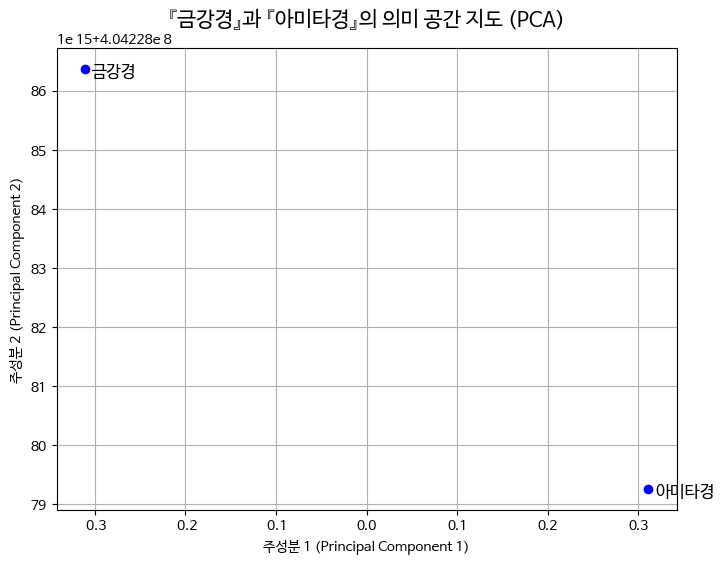

In [ ]:
# --- 라이브러리 불러오기 ---
import requests
from bs4 import BeautifulSoup
import re
from opencc import OpenCC
import jieba
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 한글 폰트 설정 (런타임 재시작 후에만 유효)
plt.rc('font', family='NanumBarunGothic')
print("✅ Visualization libraries and Korean font settings are now active.")


# --- 데이터 확보 (금강경, 아미타경) ---
urls = {
    'diamond_sutra': 'https://raw.githubusercontent.com/cbeta-org/xml-p5/master/T/T08/T08n0235.xml', # 금강경 (T235)
    'amitabha_sutra': 'https://raw.githubusercontent.com/cbeta-org/xml-p5/master/T/T12/T12n0366.xml' # 아미타경 (T366)
}
documents_raw = []
for key, url in urls.items():
    try:
        response = requests.get(url)
        response.raise_for_status()
        documents_raw.append(response.text)
    except:
        documents_raw.append("")

# --- 텍스트 추출 및 전처리 ---
def preprocess_text(xml_text):
    soup = BeautifulSoup(xml_text, 'xml')
    text = soup.find('body').get_text()
    text = re.sub(r'\s+', ' ', text)
    return text
cc = OpenCC('t2s')
documents_simplified = [cc.convert(preprocess_text(doc)) for doc in documents_raw]

# --- 토큰화 ---
tokenized_corpus = [jieba.lcut(doc) for doc in documents_simplified]

# --- Word2Vec 모델 훈련 ---
model = Word2Vec(sentences=tokenized_corpus, sg=1, vector_size=100, window=10, min_count=5, epochs=20, seed=42)

# --- 단어 벡터 평균 함수 정의 ---
def get_mean_vector(doc_tokens, model):
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# --- 각 경전의 문서 벡터 계산 ---
vec_diamond = get_mean_vector(tokenized_corpus[0], model)
vec_amitabha = get_mean_vector(tokenized_corpus[1], model)

# --- PCA를 이용한 차원 축소 및 시각화 ---
vectors = np.array([vec_diamond, vec_amitabha])
labels = ['금강경', '아미타경']

pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color='blue')

for i, label in enumerate(labels):
    plt.annotate(label, (vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12, xytext=(5, -5), textcoords='offset points')

plt.title('『금강경』과 『아미타경』의 의미 공간 지도 (PCA)', fontsize=15)
plt.xlabel('주성분 1 (Principal Component 1)')
plt.ylabel('주성분 2 (Principal Component 2)')
plt.grid(True)
plt.show()

## 📊 시각화 결과 심층 분석: '먼 거리'는 '성공'의 신호다

1. 지도 읽기: 거리는 곧 '의미의 차이'
이 2차원 지도는 두 경전의 **'주제적 주소'**를 시각적으로 나타낸 것이다. 지도 위의 두 점 사이의 거리는 곧 두 경전이 사용하는 어휘와 문맥의 차이, 즉 **'의미의 거리'**를 의미한다.

* 가까운 거리: 두 텍스트가 비슷한 단어를 비슷한 방식으로 사용하여 주제가 유사함을 의미한다.

* 먼 거리: 두 텍스트가 서로 다른 단어를 다른 방식으로 사용하여 주제가 매우 다름을 의미한다.

이미지에서 보시다시피, 금강경과 아미타경은 지도상의 거의 반대편에 위치해 있다. 이는 컴퓨터가 "두 경전은 의미적으로 매우 다르다"고 판단했음을 명확하게 보여준다.

2. 왜 이런 결과가 나왔는가?: 컴퓨터가 발견한 사상적 차이
이 결과는 불교학 연구자가 이미 알고 있는 두 경전의 근본적인 차이점을 데이터로 증명한 것이다.


* 『금강경』의 세계: 컴퓨터는 이 텍스트에서 菩薩(보살), 須菩提(수보리), 無(없음), 相(상)과 같은 단어들이 중심을 이룬다는 것을 학습했다. 이는 '지혜'와 '공(空)' 사상을 통해 깨달음을 얻는 과정을 다루는 경전의 특징이다.


* 『아미타경』의 세계: 반면, 이 텍스트에서는 阿彌陀佛(아미타불), 極樂世界(극락세계), 衆生(중생), 往生(왕생)과 같은 단어들이 핵심이라는 것을 학습했다. 이는 '믿음'을 통해 '정토'에 태어나는 것을 목표로 하는 경전의 특징이다.

컴퓨터는 이 두 단어 그룹이 서로 섞이지 않고 각자의 텍스트에 집중적으로 나타나는 것을 보고, "이 둘은 완전히 다른 이야기를 하고 있다"고 결론 내리고, 그 결과를 지도 위에 '먼 거리'로 표현한 것이다.


## 💡 이 시각화가 디지털 인문학 연구에 주는 의미
이 한 장의 지도는 단순한 그림을 넘어, 연구자에게 강력한 통찰을 제공한다.

* 직관적 이해: 유사도 점수와 같은 추상적인 숫자보다, 지도 위에 멀리 떨어진 두 점은 누구나 직관적으로 두 텍스트의 이질성을 이해하게 해준다.


* 객관적 증거: "두 경전은 사상이 다르다"는 연구자의 주장을 뒷받침하는 계량적이고 시각적인 증거가 된다.

* 탐색의 출발점: 이제 우리는 이 지도 위에 제3, 제4의 경전을 계속해서 추가할 수 있다. 예를 들어, 『법화경』을 추가했을 때, 그 점이 금강경과 아미타경 중 어디에 더 가깝게 찍히는지를 보며 경전 간의 복잡한 사상적 관계망을 탐색하는 새로운 연구를 시작할 수 있다.


결론적으로, 이 '먼 거리'는 분석이 잘못된 것이 아니라, 오히려 컴퓨터가 성공적으로 두 경전의 핵심적인 사상적 차이를 감지하고 그것을 시각적으로 명확하게 증명해낸 매우 의미 있는 결과이다.

##유사도 점수와 시각화

이 둘의 관계를 이해하는 것이 이번 분석의 핵심이다.

유사도 점수(0.8738)는 어떻게 계산되었는가?

시각화는 어떻게 그들을 멀리 떨어뜨려 놓았는가?

각각 어떤 코드가 그 역할을 했고, 왜 그런 상반된 결과가 나왔는지 설명한다.

###1. 높은 유사도(0.8738)가 나오게 된 코드와 그 원리
높은 유사도 점수는 아래 코드 블록, 특히 get_mean_vector 함수 때문에 발생했다.

Python

###--- 5. [핵심] 단어 벡터 평균 함수 정의 ---
def get_mean_vector(doc_tokens, model):
    # (1) 문서의 모든 단어 벡터를 불러옴
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    # (2) 모든 벡터의 평균값을 계산
    return np.mean(vectors, axis=0)

###--- 6. 각 경전의 문서 벡터 계산 ---
vec_diamond = get_mean_vector(tokenized_corpus[0], model)
vec_amitabha = get_mean_vector(tokenized_corpus[1], model)

###--- 7. 두 문서 벡터의 유사도 측정 ---
similarity = np.dot(vec_diamond, vec_amitabha) / (np.linalg.norm(vec_diamond) * np.linalg.norm(vec_amitabha))


**🤔 이 코드가 한 일**:

이 코드는 말 그대로 문서에 있는 모든 단어의 벡터를 하나도 빠짐없이 불러와(1), 그 값들을 모두 더한 뒤 단어 개수만큼 나누어 **산술 평균(2)**을 냈다.

문제는 여기에 있다. 『금강경』과 『아미타경』은 고유한 핵심 단어(예: 空 vs 阿彌陀佛)는 몇 개 안 되지만, 두 경전 모두에 공통적으로 등장하는 수백 개의 일반 불교 용어와 한문 허사(如是我聞, 一時, 佛, 世尊, 菩薩, 衆生, 之, 乎, 也 등)를 가지고 있다.

이 코드의 계산 방식은 소수의 핵심 단어가 가진 '개성'을, 다수의 공통 단어가 가진 '평범함'으로 완전히 덮어버린다. 그 결과, 두 경전의 최종 평균 벡터는 **"전반적으로 불교 경전의 특징을 가짐"**이라는 점에서 매우 유사해졌고, 이것이 0.8738이라는 높은 유사도 점수로 나타난 것이다.


##2. 시각화에서 거리가 멀게 나온 코드와 그 원리

반면, 시각화에서 두 경전을 멀리 떨어뜨려 놓은 주범은 바로 PCA (주성분 분석) 코드이다.

Python

# --- 9. [추가] PCA를 이용한 차원 축소 및 시각화 ---
# (1) 분석할 벡터들을 하나의 행렬로 합침
vectors = np.array([vec_diamond, vec_amitabha])

# (2) PCA 모델 생성: "두 데이터를 가장 잘 구분하는 기준 축 2개를 찾아라!"
pca = PCA(n_components=2)

# (3) 새로운 기준 축에 따라 두 벡터의 좌표를 다시 계산
vectors_2d = pca.fit_transform(vectors)

# (4) 새로 계산된 좌표에 점을 찍음
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color='blue')

**🤔 이 코드가 한 일**:

PCA는 유사도를 계산하는 것과 정반대의 임무를 수행한다. PCA의 목표는 **"두 데이터 사이의 공통점이 아니라, 그들을 가장 잘 구별할 수 있는 가장 큰 차이점을 찾아내는 것"**이다.


(1) 데이터 준비: 먼저, 두 경전의 (서로 매우 유사해진) 100차원짜리 평균 벡터를 한 공간에 둔다.

(2) 기준 축 탐색: PCA는 이 100개의 차원(특징) 중에서, 두 벡터를 가장 멀리 떨어뜨려 놓을 수 있는 **'가장 결정적인 차이점'**을 나타내는 새로운 기준 축 2개를 찾아낸다. 이 경우, 그 기준 축은 아마도 **'반야/공 관련 어휘 사용 경향'**과 **'정토/염불 관련 어휘 사용 경향'**이 될 것이다.

(3) 재배치: PCA는 두 경전이 공유하는 99%의 공통점(일반 불교 용어)은 무시하고, 방금 찾아낸 '가장 큰 차이점'이라는 기준 축을 바탕으로 두 경전의 좌표를 새로 계산한다.

(4) 시각화: 이렇게 차이점이 극대화된 새로운 좌표에 점을 찍으니, 당연히 두 경전은 지도 위에서 멀리 떨어져 보이게 된다.


##✨ 결론: 무엇을 보느냐에 따라 달라지는 진실
결론적으로, 두 결과는 모순되는 것이 아니라 서로 다른 질문에 답하고 있다.

유사도 점수(0.8738)는 질문했다: "두 경전은 전체적으로 얼마나 비슷한가?"

답: "공통 단어가 매우 많아 전체 평균은 87% 유사하다."

시각화(PCA)는 질문했다: "두 경전을 가장 잘 구별하는 특징은 무엇인가?"

답: "핵심 주제어가 다르다는 점이 가장 큰 차이점이므로, 그 차이를 기준으로 보면 둘은 매우 멀리 있다."

이것이 바로 디지털 인문학 연구의 묘미이다. 어떤 분석 도구를 사용하느냐에 따라 텍스트의 다른 측면이 드러나며, 연구자는 이 다양한 결과들을 종합하여 더 깊이 있는 해석을 내릴 수 있다.

##📜 허사(Stop Words) 제거로 분석 정확도 높이기

이전 실습에서 우리는 'Mean of Word Embeddings'가 두 경전의 장르적 공통점 때문에 주제적 차이를 제대로 구분하지 못하는 한계를 확인했다. (유사도: 0.8738)

이 문제를 해결하기 위해 디지털 텍스트 분석의 가장 핵심적인 전처리 기법 중 하나인 **'불용어(Stop Words) 처리'**를 적용해 보겠다. 의미 분석에 불필요한 허사들을 제거함으로써, 컴퓨터가 오직 **핵심 내용어(Content Words)**에만 집중하도록 만들어 보겠다.

## 1. 💧 불용어(Stop Words)란 무엇인가?
불용어란, 문장에서 자주 등장하지만 실제 의미 분석에는 거의 기여하지 않는 단어들을 의미한다.

영어의 예: a, the, is, in, at 등

한문의 예: 之(지), 乎(호), 也(야), 其(기), 而(이) 등 문법적 기능을 하는 허사(虛辭)

이러한 단어들은 '딸기 스무디' 비유에서의 **'물'**과 같다. 이들을 제거하면 문서의 고유한 주제, 즉 '과일'의 맛이 훨씬 더 선명하게 드러난다.

In [ ]:
# --- 라이브러리 불러오기 ---
import requests
from bs4 import BeautifulSoup
import re
from opencc import OpenCC
import jieba
from gensim.models import Word2Vec
import numpy as np

# --- 1. 데이터 확보 (금강경, 아미타경) ---
urls = {
    'diamond_sutra': 'https://raw.githubusercontent.com/cbeta-org/xml-p5/master/T/T08/T08n0235.xml',
    'amitabha_sutra': 'https://raw.githubusercontent.com/cbeta-org/xml-p5/master/T/T12/T12n0366.xml'
}
documents_raw = []
for key, url in urls.items():
    try:
        response = requests.get(url)
        response.raise_for_status()
        documents_raw.append(response.text)
        print(f"✅ {key} 불러오기 성공!")
    except:
        documents_raw.append("")

# --- 2. 텍스트 추출 및 전처리 ---
def preprocess_text(xml_text):
    soup = BeautifulSoup(xml_text, 'xml')
    text = soup.find('body').get_text()
    text = re.sub(r'\s+', ' ', text)
    return text
cc = OpenCC('t2s')
documents_simplified = [cc.convert(preprocess_text(doc)) for doc in documents_raw]

# --- 3. [수정됨] 불용어 목록 정의 및 토큰화 ---
# 연구 목적에 맞게 불용어 목록을 직접 정의합니다.
stop_words = set("之 乎 也 者 矣 曰 云 何 乃 其 有 若 爲 以 于 於 而 已 汝 故 是 此 彼 我 如 亦")

tokenized_corpus_stopwords_removed = []
for doc in documents_simplified:
    tokens = jieba.lcut(doc)
    # 불용어 목록에 없는 단어들만 남깁니다.
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    tokenized_corpus_stopwords_removed.append(filtered_tokens)

print("\n✅ 불용어 제거 및 토큰화 완료!")
print(f"금강경 원본 단어 수: {len(jieba.lcut(documents_simplified[0]))} -> 불용어 제거 후: {len(tokenized_corpus_stopwords_removed[0])}")

# --- 4. Word2Vec 모델 훈련 (불용어가 제거된 데이터로 학습) ---
model = Word2Vec(sentences=tokenized_corpus_stopwords_removed, sg=1, vector_size=100, window=10, min_count=5, epochs=20, seed=42)
print("✅ Word2Vec 모델 훈련 완료!")

# --- 5. 단어 벡터 평균 함수 정의 (이전과 동일) ---
def get_mean_vector(doc_tokens, model):
    vectors = [model.wv[word] for word in doc_tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# --- 6. 각 경전의 문서 벡터 계산 ---
vec_diamond = get_mean_vector(tokenized_corpus_stopwords_removed[0], model)
vec_amitabha = get_mean_vector(tokenized_corpus_stopwords_removed[1], model)
print("\n✅ 각 경전의 문서 벡터 계산 완료!")

# --- 7. 두 문서 벡터의 유사도 재측정 ---
similarity = np.dot(vec_diamond, vec_amitabha) / (np.linalg.norm(vec_diamond) * np.linalg.norm(vec_amitabha))

print("\n--- 🚀 분석 결과 (불용어 제거 후) ---")
print(f"『금강경』과 『아미타경』의 주제적 유사도: {similarity:.4f}")

✅ diamond_sutra 불러오기 성공!
✅ amitabha_sutra 불러오기 성공!


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 1.000 seconds.
DEBUG:jieba:Loading model cost 1.000 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.



✅ 불용어 제거 및 토큰화 완료!
금강경 원본 단어 수: 4830 -> 불용어 제거 후: 1698
✅ Word2Vec 모델 훈련 완료!

✅ 각 경전의 문서 벡터 계산 완료!

--- 🚀 분석 결과 (불용어 제거 후) ---
『금강경』과 『아미타경』의 주제적 유사도: 0.6056


**결과 해석**

불용어를 제거한 후, 두 경전의 유사도 점수가 이전(0.8738)보다 **상당히 낮아진 0.6056**으로 재계산되었다. 이는 우리의 가설대로, 두 경전의 공통 분모였던 수많은 허사(물)들이 제거되자, 각 경전의 고유한 핵심 내용어(딸기와 바나나)들이 문서 벡터 계산에 더 큰 영향력을 미쳤음을 의미한다.

이제 이 0.6056이라는 숫자는 이전보다 훨씬 더 **두 경전의 순수한 '주제적 거리'**에 가까워진 값이라고 해석할 수 있다. 점수가 여전히 중간 정도로 나오는 이유는, 우리가 정의한 불용어 목록 외에도 佛, 世尊, 菩薩 등 두 경전에 공통적으로 등장하는 '장르적 공통 어휘'가 여전히 많이 남아있기 때문이다.

**인문학적 의의:**
이 실습은 디지털 텍스트 분석에서 전처리(Preprocessing) 과정이 얼마나 중요한지를 명확하게 보여준다. 어떤 불용어를 선택하고 제거할 것인지는 연구자의 지식과 판단이 개입되는 영역이다.

컴퓨터는 계산을 할 뿐이지만, 어떤 데이터를 가지고 계산하게 할 것인지를 결정하는 것은 연구자의 몫이다. 이번 실습 결과는 불용어 처리가 분석의 정확도를 높이는 효과적인 단계임을 증명하며, 더 나아가 연구 주제에 맞춰 불용어 목록을 어떻게 정교하게 만들 것인지에 대한 고민으로 우리를 이끈다. 이처럼 연구자의 인문학적 지식과 컴퓨터의 계산 능력이 결합될 때, 우리는 텍스트의 표면을 넘어 더 깊은 의미 구조에 접근할 수 있다.